# Siamese architecture

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from siamese_data import MNIST
%matplotlib inline

## The data set: MNIST
Let's have a look at the MNIST data set. The MNIST data set is a labeled data set consisting in 70,000 handwritten digits (see http://yann.lecun.com/exdb/mnist/ for more information). It is often used to benchmarck classification algorithms.

Below we show some images from MNIST.

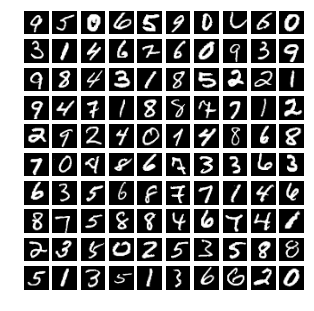

In [2]:
data = MNIST() # load the data
examples_n = 100 # display some images
indexes = np.random.choice(range(len(data.y)), examples_n, replace=False)
fig = plt.figure(figsize=(5,5))
for i in range(1, examples_n + 1):
    a = fig.add_subplot(np.sqrt(examples_n), np.sqrt(examples_n), i)
    a.axis('off')
    image = data.x[indexes[i-1]].reshape((28, 28)) # reshape the image from (784) to (28, 28).
    a.imshow(image, cmap='Greys_r');

## Siamese network

A *siamese network* is a network consisting in two identical (hence the name) neural networks with tied weights (the weights of the two networks are the same). Given two inputs $X_1$ and $X_2$, $X_1$ is fed to the first network and $X_2$ to the second network. Then, the outputs from the two networks are combined and produce an answer to the question: **are the two inputs similar or different?**

For more details regarding siamese networks, we refer the interested reader to the paper that introduced siamese networks in 1993: *Signature Verification using a "Siamese" Time Delay Neural Network* (Bromley and Le Cun).

### Architecture of the siamese network

The two networks of the siamese architecture can be any suitable type of networks. Here, we use a simple bi-directional LSTM (it could have been a multilayer convolutional neural networks for instance).

An image from MNIST is a $28\times28$ image, thus we naturally consider an image as a sequence of $28$ rows (or columns) vectors of shape $(1, 28)$ (or $(28, 1)$).

In [3]:
n_inputs = 28 # dimension of each of the input vectors
n_steps = 28 # sequence length
n_hidden = 128 # number of neurons of the bi-directional LSTM
n_classes = 2 # two possible classes, either `same` of `different`

In [4]:
#tf.reset_default_graph()

We create two placeholders to feed the data to the siamese network. $x_1$ will be fed to the first network and $x_2$ to the second network.

In [5]:
x1 = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs]) # placeholder for the first network (image 1)
x2 = tf.placeholder(tf.float32, shape=[None, n_steps, n_inputs]) # placeholder for the second network (image 2)

# placeholder for the label. `[1, 0]` for `same` and `[0, 1]` for `different`.
y = tf.placeholder(tf.float32, shape=[None, n_classes]) 

We create the model.

In [6]:
def reshape_input(x_):
    """
    Reshape the inputs to match the shape requirements of the function
    `tf.nn.bidirectional_rnn`
    
    Args:
        x_: a tensor of shape `(batch_size, n_steps, n_inputs)`
        
    Returns:
        A `list` of length `n_steps` with its elements being tensors of shape `(batch_size, n_inputs)`
    """
    x_ = tf.transpose(x_, [1, 0, 2]) # shape: (n_steps, batch_size, n_inputs)
    x_ = tf.split(0, n_steps, x_) # a list of `n_steps` tensors of shape (1, batch_size, n_steps)
    return [tf.squeeze(z, [0]) for z in x_] # remove size 1 dimension --> (batch_size, n_steps)    


def siamese_model(x1_, x2_):
    """
    Create the siamese network.
    
    Args:
        x1_: a tensor of shape `(batch_size, n_steps, n_inputs)` containing a batch of images
            for the first network.
        x2_: a tensor of shape similar to `x1_` containing a batch of images for the second network.
        
    Returns:
        A tensor of shape `(batch_size, n_classes)` containing the unscaled predictions.
    """

    # We reshape the inputs to match the shape requirements of `tf.nn.bidirectinal_rnn`
    x1_, x2_ = reshape_input(x1_), reshape_input(x2_)
    
    # A bidirectional RNN consists of a forward cell and a backward cell. The two cells are independent.
    lstm_fw_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, state_is_tuple=True) # Forwward cell
    lstm_bw_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, state_is_tuple=True) # Backward cell
    
    
    with tf.variable_scope('siamese_network') as scope:
        with tf.name_scope('Bi_LSTM_1'):
            outputs1, last_state_fw1, last_state_bw1 = tf.nn.bidirectional_rnn(
                                            lstm_fw_cell, lstm_bw_cell, x1_,
                                            dtype=tf.float32)
        with tf.name_scope('Bi_LSTM_2'):
            scope.reuse_variables() # tied weights (reuse the weights from `Bi_LSTM_1` for `Bi_LSTM_2`)
            outputs2, last_state_fw2, last_state_bw2 = tf.nn.bidirectional_rnn(
                                            lstm_fw_cell, lstm_bw_cell, x2_,
                                            dtype=tf.float32)
    
    
    # Weights and biases for the last layer that connects the outputs from the two networks.
    weights = tf.get_variable('weigths_out', shape=[4 * n_hidden, n_classes],
                    initializer=tf.random_normal_initializer(stddev=1.0/float(n_hidden)))
    biases = tf.get_variable('biases_out', shape=[n_classes])
    
    #outputs_diff = tf.abs(outputs1[-1] - outputs2[-1])
    last_state1 = tf.concat(1, [last_state_fw1[0], last_state_bw1[0],
                                  last_state_fw1[1], last_state_bw1[1]])
    last_state2 = tf.concat(1, [last_state_fw2[0], last_state_bw2[0],
                                  last_state_fw2[1], last_state_bw2[1]])
    last_states_diff = tf.abs(last_state1 - last_state2)
    return tf.matmul(last_states_diff, weights) + biases

In [7]:
logits = siamese_model(x1, x2) # Unscaled logits. They are scaled using softmax in the loss function.
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.AdamOptimizer().minimize(loss)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1)) 
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

We now train the network.

In [11]:
init = tf.initialize_all_variables()

max_iter = 1000 # maximum number of iteration for training
batch_train = 128 # batch size for training
batch_test = 512 # batch size for testing
display = 50 # display the training loss and accuracy every `display` step
n_test = 200 # test the network every `n_test` step

with tf.Session() as sess:
    sess.run(init) # initialize all variables
    print('Network training begins.')
    for i in range(1, max_iter + 1):
        # We retrieve a batch of data from the training set
        batch_x1, batch_x2, batch_y = data.get_next_batch(batch_train, phase='train')
        # We feed the data to the network for training
        feed_dict = {x1: batch_x1, x2: batch_x2, y: batch_y}
        _, loss_, accuracy_ = sess.run([optimizer, loss, accuracy], feed_dict=feed_dict)
        
        if i % display == 0:
            print('step %i, training loss: %.5f, training accuracy: %.3f' % (i, loss_, accuracy_))
        
        # Testing the network
        if i % n_test == 0:
            # Retrieving data from the test set
            batch_x1, batch_x2, batch_y = data.get_next_batch(batch_test, phase='test')
            feed_dict = {x1: batch_x1, x2: batch_x2, y: batch_y}
            accuracy_test = sess.run(accuracy, feed_dict=feed_dict)
            print('testing step %i, accuracy %.3f' % (i, accuracy_test))
    print('********************************')
    print('Training finished.')
    
    # testing the trained network on a large sample
    batch_x1, batch_x2, batch_y = data.get_next_batch(10000, phase='test')
    feed_dict = {x1: batch_x1, x2: batch_x2, y: batch_y}
    accuracy_test = sess.run(accuracy, feed_dict=feed_dict)
    print('********************************')
    print('Testing the network.')
    print('Network accuracy %.3f' % (accuracy_test))
    print('********************************')

Network training begins.
step 50, training loss: 0.52419, training accuracy: 0.812
step 100, training loss: 0.44105, training accuracy: 0.805
step 150, training loss: 0.37851, training accuracy: 0.844
step 200, training loss: 0.39680, training accuracy: 0.820
testing step 200, accuracy 0.834
step 250, training loss: 0.44333, training accuracy: 0.797
step 300, training loss: 0.36620, training accuracy: 0.805
step 350, training loss: 0.40499, training accuracy: 0.844
step 400, training loss: 0.37166, training accuracy: 0.836
testing step 400, accuracy 0.873
step 450, training loss: 0.28268, training accuracy: 0.906
step 500, training loss: 0.34594, training accuracy: 0.852
step 550, training loss: 0.34155, training accuracy: 0.844
step 600, training loss: 0.36388, training accuracy: 0.852
testing step 600, accuracy 0.879
step 650, training loss: 0.19803, training accuracy: 0.922
step 700, training loss: 0.20295, training accuracy: 0.922
step 750, training loss: 0.24589, training accuracy

Future improvements:
- add regularization (dropouts and l2-regularization),
- explore one-shot learning (maybe in another notebook)